In [1]:
msg = "Hello World"
print(msg)

Hello World


In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob

raw_data_files = glob.glob('../ansible/.results-3/bpftrace/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------+
|value                                                        |
+-------------------------------------------------------------+
|Attaching 12 probes...                                       |
|Tracing latency of network stack funtions. Hit Ctrl-C to end.|
|@q1[openssl]: count 207, average 1343, total 278128          |
|@q1[ksoftirqd/169]: count 3, average 3890, total 11672       |
|@q1[kworker/169:0]: count 1, average 7925, total 7925        |
|                                                             |
|@q2[ksoftirqd/169]: count 25, average 874, total 21855       |
|@q2[kworker/169:0]: count 2, average 3577, total 7154        |
|@q2[openssl]: count 943, average 3668, total 3459197         |
|                                                             |
+-------------------------------------------------------------+
only showing top 10 rows



In [3]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['Attaching 12 probes...',
 'Tracing latency of network stack funtions. Hit Ctrl-C to end.',
 '@q1[openssl]: count 207, average 1343, total 278128',
 '@q1[ksoftirqd/169]: count 3, average 3890, total 11672',
 '@q1[kworker/169:0]: count 1, average 7925, total 7925',
 '',
 '@q2[ksoftirqd/169]: count 25, average 874, total 21855',
 '@q2[kworker/169:0]: count 2, average 3577, total 7154',
 '@q2[openssl]: count 943, average 3668, total 3459197',
 '',
 '',
 '@q4[openssl]: count 9905, average 951, total 9428804',
 '@q4[ksoftirqd/169]: count 87, average 1008, total 87733',
 '@q4[kworker/169:0]: count 11, average 3602, total 39625',
 '']

In [4]:
bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
ps = [re.search(bpftrace_ps_pattern, item).groups()
           if re.search(bpftrace_ps_pattern, item)
           else None
           for item in sample_logs]
ps

[None,
 None,
 ('q1', 'openssl', '207', '1343', '278128', ''),
 ('q1', 'ksoftirqd/169', '3', '3890', '11672', ''),
 ('q1', 'kworker/169:0', '1', '7925', '7925', ''),
 None,
 ('q2', 'ksoftirqd/169', '25', '874', '21855', ''),
 ('q2', 'kworker/169:0', '2', '3577', '7154', ''),
 ('q2', 'openssl', '943', '3668', '3459197', ''),
 None,
 None,
 ('q4', 'openssl', '9905', '951', '9428804', ''),
 ('q4', 'ksoftirqd/169', '87', '1008', '87733', ''),
 ('q4', 'kworker/169:0', '11', '3602', '39625', ''),
 None]

In [5]:
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
cs = [re.search(bpftrace_cs_pattern, item).groups()
           if re.search(bpftrace_cs_pattern, item)
           else None
           for item in sample_logs]
cs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+---------+
|cs_count|cs_average| cs_total|
+--------+----------+---------+
|    2334|     57663|134585847|
|    2522|      6337| 15982376|
|    2140|      6309| 13501724|
|    2087|      6294| 13135939|
|    2177|      7298| 15888887|
|    2349|      6535| 15350861|
|    2128|      6306| 13420729|
|    2039|      5573| 11364223|
|    2065|      6394| 13204434|
|    2453|      7067| 17337607|
|    2826|     14278| 40351895|
|    2117|      7387| 15639138|
|    2029|      5585| 11332246|
|    2369|      6997| 16576889|
|    2252|      7168| 16143316|
+--------+----------+---------+
only showing top 15 rows



In [7]:
print(bpftrace_cs_df.toPandas().to_numpy()[0])

['2334' '57663' '134585847']


In [8]:
from pyspark.sql.functions import regexp_extract

bpftrace_logs_df = base_df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
bpftrace_logs_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|
+-----+-------------+---------+-----------+---------+
|   q1|      openssl|      207|       1343|   278128|
|   q1|ksoftirqd/169|        3|       3890|    11672|
|   q1|kworker/169:0|        1|       7925|     7925|
|   q2|ksoftirqd/169|       25|        874|    21855|
|   q2|kworker/169:0|        2|       3577|     7154|
|   q2|      openssl|      943|       3668|  3459197|
|   q4|      openssl|     9905|        951|  9428804|
|   q4|ksoftirqd/169|       87|       1008|    87733|
|   q4|kworker/169:0|       11|       3602|    39625|
|   q5|      openssl|    74952|        432| 32386336|
|   q5|ksoftirqd/169|      609|        440|   268345|
|   q5|kworker/169:0|       80|        721|    57712|
|   q1|      openssl|      367|       1184|   434848|
|   q1|ksoftirqd/169|        7|       3317|    23223|
|   q1|kworker/169:0|        4|       4678|    18715|
+-----+-------------+-------

In [9]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+---------+
|cs_count|cs_average| cs_total|
+--------+----------+---------+
|    2334|     57663|134585847|
|    2522|      6337| 15982376|
|    2140|      6309| 13501724|
|    2087|      6294| 13135939|
|    2177|      7298| 15888887|
|    2349|      6535| 15350861|
|    2128|      6306| 13420729|
|    2039|      5573| 11364223|
|    2065|      6394| 13204434|
|    2453|      7067| 17337607|
|    2826|     14278| 40351895|
|    2117|      7387| 15639138|
|    2029|      5585| 11332246|
|    2369|      6997| 16576889|
|    2252|      7168| 16143316|
+--------+----------+---------+
only showing top 15 rows



In [10]:
cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]
print(cs_array)

['2334' '57663' '134585847']


In [11]:
from pyspark.sql.functions import lit

bpftrace_res_df = bpftrace_logs_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
bpftrace_res_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|
+-----+-------------+---------+-----------+---------+--------+----------+---------+
|   q1|      openssl|      207|       1343|   278128|    2334|     57663|134585847|
|   q1|ksoftirqd/169|        3|       3890|    11672|    2334|     57663|134585847|
|   q1|kworker/169:0|        1|       7925|     7925|    2334|     57663|134585847|
|   q2|ksoftirqd/169|       25|        874|    21855|    2334|     57663|134585847|
|   q2|kworker/169:0|        2|       3577|     7154|    2334|     57663|134585847|
|   q2|      openssl|      943|       3668|  3459197|    2334|     57663|134585847|
|   q4|      openssl|     9905|        951|  9428804|    2334|     57663|134585847|
|   q4|ksoftirqd/169|       87|       1008|    87733|    2334|     57663|134585847|
|   q4|kworker/169:0|       11|       3602|    39625|    2334|     57663|134

In [12]:
raw_data_files = glob.glob('../ansible/.results-3/iperf/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+---------------------------------------------------------------------------------+
|value                                                                            |
+---------------------------------------------------------------------------------+
|------------------------------------------------------------                     |
|Server listening on UDP port 5001                                                |
|Receiving 1470 byte datagrams                                                    |
|UDP buffer size:  208 KByte (default)                                            |
|------------------------------------------------------------                     |
|[  3] local 10.0.0.2 port 5001 connected with 10.0.0.1 port 44772                |
|[ ID] Interval       Transfer     Bandwidth        Jitter   Lost/Total Datagrams |
|[  3]  0.0-59.9 sec  8.37 GBytes  1.20 Gbits/sec   0.009 ms 10895/6122450 (0.18%)|
+--------------------------------

In [13]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(iperf_s_pattern, item).groups()
           if re.search(iperf_s_pattern, item)
           else None
           for item in sample_logs]
cs

[('', '', '', '', '', '', ''),
 None,
 None,
 None,
 ('', '', '', '', '', '', ''),
 None,
 None,
 ('59.9', '8.37', '1.20', '0.009', '10895/6122450', '0.18', '%)')]

In [14]:
raw_data_files = glob.glob('../ansible/.results-3/openssl/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-----------------------------------------------------------------------------+
|value                                                                        |
+-----------------------------------------------------------------------------+
|Doing aes-256 cbc for 10s on 16 size blocks: 88548495 aes-256 cbc's in 8.58s |
|Doing aes-256 cbc for 10s on 64 size blocks: 21858272 aes-256 cbc's in 8.05s |
|Doing aes-256 cbc for 10s on 256 size blocks: 5486645 aes-256 cbc's in 7.92s |
|Doing aes-256 cbc for 10s on 1024 size blocks: 1378327 aes-256 cbc's in 8.13s|
|Doing aes-256 cbc for 10s on 8192 size blocks: 172276 aes-256 cbc's in 8.08s |
|Doing aes-256 cbc for 10s on 16384 size blocks: 86185 aes-256 cbc's in 8.13s |
+-----------------------------------------------------------------------------+



In [15]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(openssl_s_pattern, item).groups()
           if re.search(openssl_s_pattern, item)
           else None
           for item in sample_logs]
cs

openssl_logs_df = base_df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')

openssl_logs_df.show(5)
cs_array = openssl_logs_df.toPandas().to_numpy()

us_time = 0.0
for a in cs_array:
    us_time += float(a[0])

us_time

+-------+
|us_time|
+-------+
|   8.58|
|   8.05|
|   7.92|
|   8.13|
|   8.08|
+-------+
only showing top 5 rows



48.89000000000001

In [16]:
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce

# schema = StructType([])
# results_df = sqlContext.createDataFrame(sc.emptyRDD(), schema)

bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'


def readFiletoDF(path) -> DataFrame:
    raw_data_files = glob.glob(path)
    raw_data_files
    return spark.read.text(raw_data_files)

def readBpftracePSLogstoDF(df: DataFrame) -> DataFrame:
    bpftrace_logs_df = df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
    return bpftrace_logs_df

def concateBpftraceCSLogstoDF(df: DataFrame, ps_df: DataFrame) -> DataFrame:
    bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
                                ).filter(' cs_count != ""')

    cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]

    bpftrace_res_df = ps_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
    
    return bpftrace_res_df

def concateIperfLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    iperf_logs_df = df.select(
                                regexp_extract('value', iperf_s_pattern, 1).alias('intval'),
                                regexp_extract('value', iperf_s_pattern, 2).alias('transfer'),
                                regexp_extract('value', iperf_s_pattern, 3).alias('rx_bandwidth'),
                                regexp_extract('value', iperf_s_pattern, 4).alias('jitter'),
                                regexp_extract('value', iperf_s_pattern, 6).alias('pkt_loss')
                                ).filter(' intval != "" ')
    
    cs_array = iperf_logs_df.toPandas().to_numpy()[0]

    iperf_res_df = in_df.withColumn("duration", lit(cs_array[0])
                    ).withColumn("rx_gbytes", lit(cs_array[1])
                    ).withColumn("rx_bandwidth", lit(cs_array[2])
                    ).withColumn("jitter", lit(cs_array[3])
                    ).withColumn("pkt_loss", lit(cs_array[4]))

    iperf_res_df.show(5)
    return iperf_res_df

def concateOpensslLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    openssl_logs_df = df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')
    
    cs_array = openssl_logs_df.toPandas().to_numpy()

    us_time = 0.0
    for a in cs_array:
        us_time += float(a[0])

    us_time

    openssl_res_df = in_df.withColumn("us_time", lit(us_time))

    return openssl_res_df

df_list = []

for x in range(1, 10):
    path = '../ansible/.results-3/bpftrace/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    ps_df = readBpftracePSLogstoDF(base_df)
    ps_cs_df = concateBpftraceCSLogstoDF(base_df, ps_df)
    df_1 = ps_cs_df.withColumn("tx_bandwidth", lit(1000 + 200*x))

    path = '../ansible/.results-3/iperf/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_2 = concateIperfLogsToDF(base_df, df_1)

    path = '../ansible/.results-3/openssl/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_3 = concateOpensslLogsToDF(base_df, df_2)

    df_list.append(df_3)

results_df = reduce(lambda x, y: x.union(y), df_list)
# results_df.show(5, truncate=False)
results_df.printSchema()


+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+
|   q1|      openssl|      207|       1343|   278128|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|
|   q1|ksoftirqd/169|        3|       3890|    11672|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|
|   q1|kworker/169:0|        1|       7925|     7925|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|
|   q2|ksoftirqd/169|       25|        874|    21855|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0

In [17]:
from pyspark.sql import SparkSession

results_df.show(5)
results_df.createOrReplaceTempView("LOGS")


df2=spark.sql("select level, tx_bandwidth, sum(pkt_count) as count, avg(rx_gbytes) as rx_bytes from LOGS group by level, tx_bandwidth")
df2.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+-----------------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average| cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|          us_time|
+-----+-------------+---------+-----------+---------+--------+----------+---------+------------+--------+---------+------------+------+--------+-----------------+
|   q1|      openssl|      207|       1343|   278128|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|48.89000000000001|
|   q1|ksoftirqd/169|        3|       3890|    11672|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|48.89000000000001|
|   q1|kworker/169:0|        1|       7925|     7925|    2334|     57663|134585847|        1200|    59.9|     8.37|        1.20| 0.009|    0.18|48.89000000000001|
|   q2|ksoftirqd/169| 


This graph shows the time taken executing packets on each level of packet processing for a given bandwith



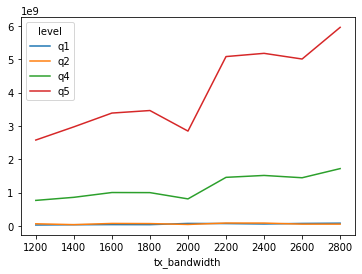

In [18]:
caption = '''
This graph shows the time taken executing packets on each level of packet processing for a given bandwith
'''

df2=spark.sql("select level, tx_bandwidth, sum(pkt_total) as time from LOGS group by level, tx_bandwidth")

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='time')

df_2.plot()
print(caption)


This graph shows the amount of time spent by the CPU operating on the userspace program for each TX bandwidth



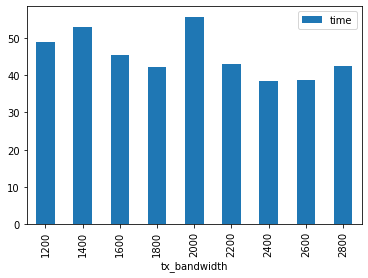

In [19]:
caption = '''
This graph shows the amount of time spent by the CPU operating on the userspace program for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(us_time) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)



This graph shows the amount of time spent handling context switches for each TX bandwidth



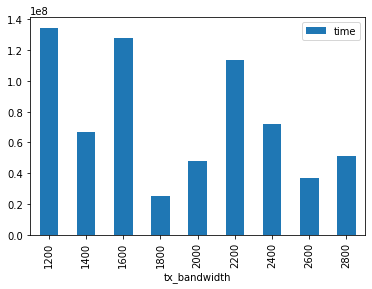

In [20]:
caption = '''
This graph shows the amount of time spent handling context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_total) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)


This graph shows the number of context switches for each TX bandwidth



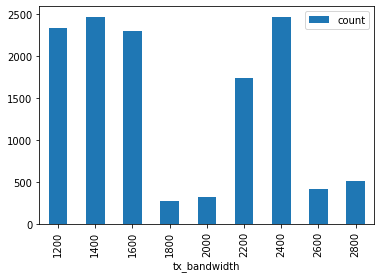

In [21]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_count) as count from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='count')
print(caption)

+-----+------------+------------------+
|level|tx_bandwidth|         rx_gbytes|
+-----+------------+------------------+
|   q4|        1200| 8.369999999999973|
|   q2|        1200| 8.369999999999973|
|   q1|        1200| 8.369999999999973|
|   q5|        1200| 8.369999999999973|
|   q1|        1400| 9.769999999999985|
|   q5|        1400| 9.769999999999985|
|   q2|        1400| 9.769999999999985|
|   q4|        1400| 9.769999999999985|
|   q5|        1600|11.099999999999971|
|   q4|        1600|11.099999999999971|
|   q2|        1600|11.099999999999973|
|   q1|        1600|11.099999999999977|
|   q4|        1800| 12.59999999999997|
|   q2|        1800| 12.59999999999997|
|   q1|        1800|12.599999999999975|
+-----+------------+------------------+
only showing top 15 rows



<AxesSubplot:xlabel='tx_bandwidth'>

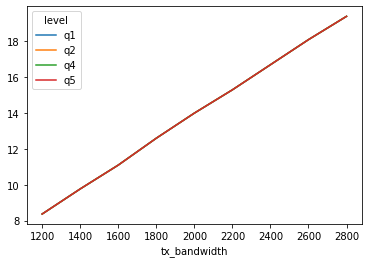

In [22]:
caption = '''
This graph shows the amount of giga bytes on each level of packet processing for a given bandwith
'''

results_df.createOrReplaceTempView("LOGS")
df2=spark.sql("select level, tx_bandwidth, avg(rx_gbytes) as rx_gbytes from LOGS group by level, tx_bandwidth order by tx_bandwidth ")
df2.show(15, truncate=True)

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='rx_gbytes')

df_2.plot()

+------------+------------------+
|tx_bandwidth|         rx_gbytes|
+------------+------------------+
|        2200|15.300000000000011|
|        1400| 9.770000000000147|
|        2600|18.100000000000165|
|        1800|12.600000000000115|
|        1600|11.100000000000104|
|        1200| 8.369999999999912|
|        2800|  19.3999999999998|
|        2400|16.700000000000003|
|        2000|              14.0|
+------------+------------------+


This graph shows the number of context switches for each TX bandwidth



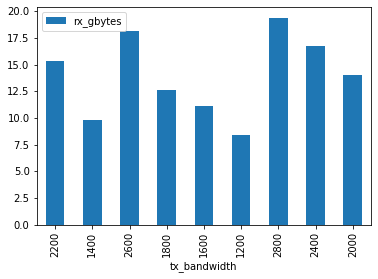

In [23]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(rx_gbytes) rx_gbytes from LOGS group by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='rx_gbytes')
print(caption)

+------------+--------------------+
|tx_bandwidth|            pkt_loss|
+------------+--------------------+
|        2200|  0.4399999999999981|
|        1400| 0.11999999999999995|
|        2600|                 0.5|
|        1800|0.014999999999999892|
|        1600|  0.3600000000000054|
|        1200| 0.18000000000000313|
|        2800|  0.6899999999999981|
|        2400| 0.20000000000000193|
|        2000|0.025999999999999857|
+------------+--------------------+


This graph shows the packet loss for each TX bandwidth



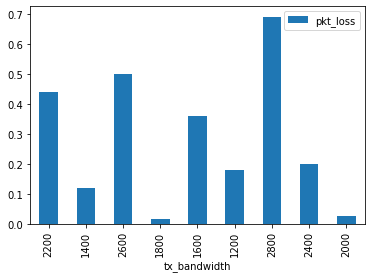

In [24]:
caption = '''
This graph shows the packet loss for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(pkt_loss) pkt_loss from LOGS group by tx_bandwidth order by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='pkt_loss')
print(caption)